In [3]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

from darts import TimeSeries

import warnings
warnings.filterwarnings('ignore')

In [5]:
  from google.colab import drive

  drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
 df = pd.read_csv('/content/drive/My Drive/weather.csv')
 df.head()

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


In [11]:
new_df = df[['date', 'temp_max']]

In [13]:
series = TimeSeries.from_dataframe(new_df, time_col='date')

<Axes: xlabel='date'>

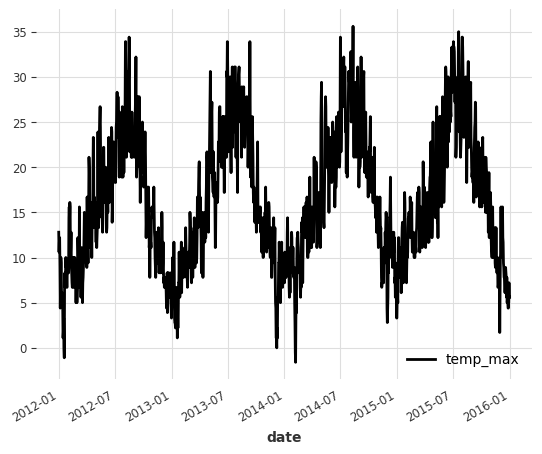

In [16]:
series.plot()

In [17]:
from darts.utils.statistics import check_seasonality

is_daily_seasonal, daily_period = check_seasonality(series, m=24, max_lag=400, alpha=0.05)
is_weekly_seasonal, weekly_period = check_seasonality(series, m=168, max_lag=400, alpha=0.05)

print(f'Daily seasonality: {is_daily_seasonal} - period = {daily_period}')
print(f'Weekly seasonality: {is_weekly_seasonal} - period = {weekly_period}')

Daily seasonality: False - period = 24
Weekly seasonality: False - period = 168


<Axes: xlabel='date'>

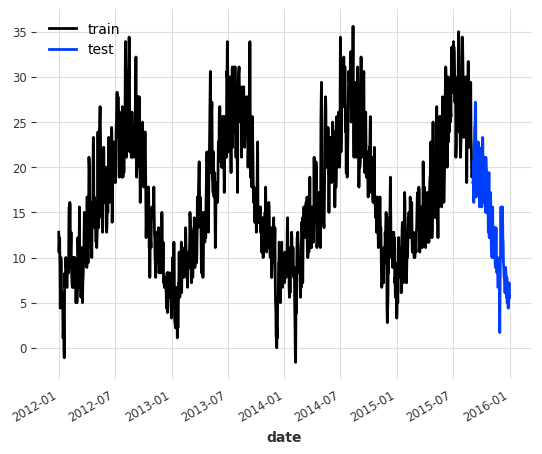

In [18]:
train, test = series[:-120], series[-120:]

train.plot(label='train')
test.plot(label='test')

In [19]:
from darts.models.forecasting.baselines import NaiveSeasonal

naive_seasonal = NaiveSeasonal(K=168)
naive_seasonal.fit(train)

pred_naive = naive_seasonal.predict(120)

<Axes: xlabel='date'>

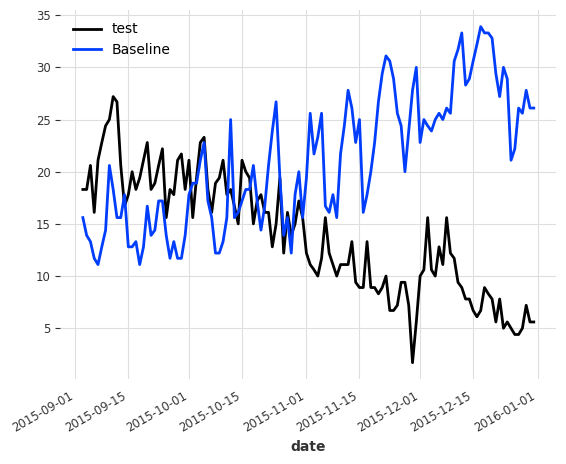

In [20]:
test.plot(label='test')
pred_naive.plot(label='Baseline')

In [21]:
from darts.metrics import mae

naive_mae = mae(test, pred_naive)

print(naive_mae)

10.725833333333332


In [22]:
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler

In [23]:
train_scaler = Scaler()
scaled_train = train_scaler.fit_transform(train)

In [24]:
nbeats = NBEATSModel(
    input_chunk_length=168,
    output_chunk_length=24,
    generic_architecture=True,
    random_state=42)

In [25]:
nbeats.fit(
    scaled_train,
    epochs=10)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 7.3 M 
---------------------------------------------------
7.3 M     Trainable params
2.3 K     Non-trainable params
7.3 M     Total params
29.323    Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


NBEATSModel(generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=168, output_chunk_length=24, random_state=42)

In [26]:
scaled_pred_nbeats = nbeats.predict(n=120)

pred_nbeats = train_scaler.inverse_transform(scaled_pred_nbeats)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

In [27]:
mae_nbeats = mae(test, pred_nbeats)

print(mae_nbeats)

3.4067567477514276


In [28]:
from darts import concatenate
from darts.utils.timeseries_generation import datetime_attribute_timeseries as dt_attr

cov = concatenate(
    [dt_attr(series.time_index, 'day', dtype=np.float32), dt_attr(series.time_index, 'week', dtype=np.float32)],
    axis='component'
)

In [29]:
cov_scaler = Scaler()
scaled_cov = cov_scaler.fit_transform(cov)

In [30]:
nbeats_cov = NBEATSModel(
    input_chunk_length=168,
    output_chunk_length=24,
    generic_architecture=True,
    random_state=42)

nbeats_cov.fit(
    scaled_train,
    past_covariates=scaled_cov,
    epochs=10
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 10.0 M
---------------------------------------------------
10.0 M    Trainable params
4.3 K     Non-trainable params
10.0 M    Total params
39.922    Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


NBEATSModel(generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=168, output_chunk_length=24, random_state=42)

In [31]:
scaled_pred_nbeats_cov = nbeats_cov.predict(past_covariates=scaled_cov, n=120)

pred_nbeats_cov = train_scaler.inverse_transform(scaled_pred_nbeats_cov)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

<Axes: xlabel='date'>

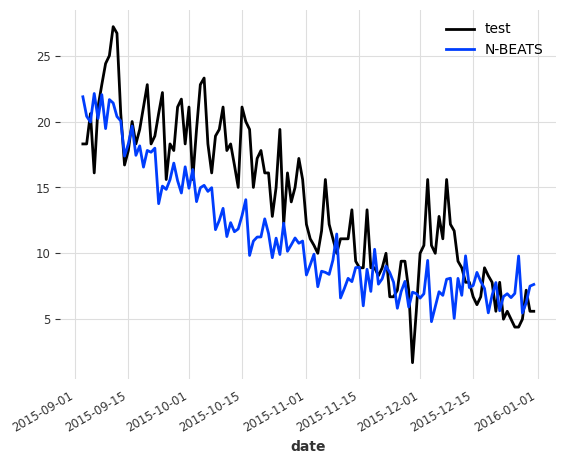

In [32]:
test.plot(label='test')
pred_nbeats.plot(label='N-BEATS')

In [33]:
mae_nbeats_cov = mae(test, pred_nbeats_cov)

print(mae_nbeats_cov)

2.489419131561108


In [ ]:
https://towardsdatascience.com/the-easiest-way-to-forecast-time-series-using-n-beats-d778fcc2ba60